# 프로젝트 : 도로 색칠하기

In [1]:
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow import data
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
data_path = "/content/drive/MyDrive/cityscapes/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


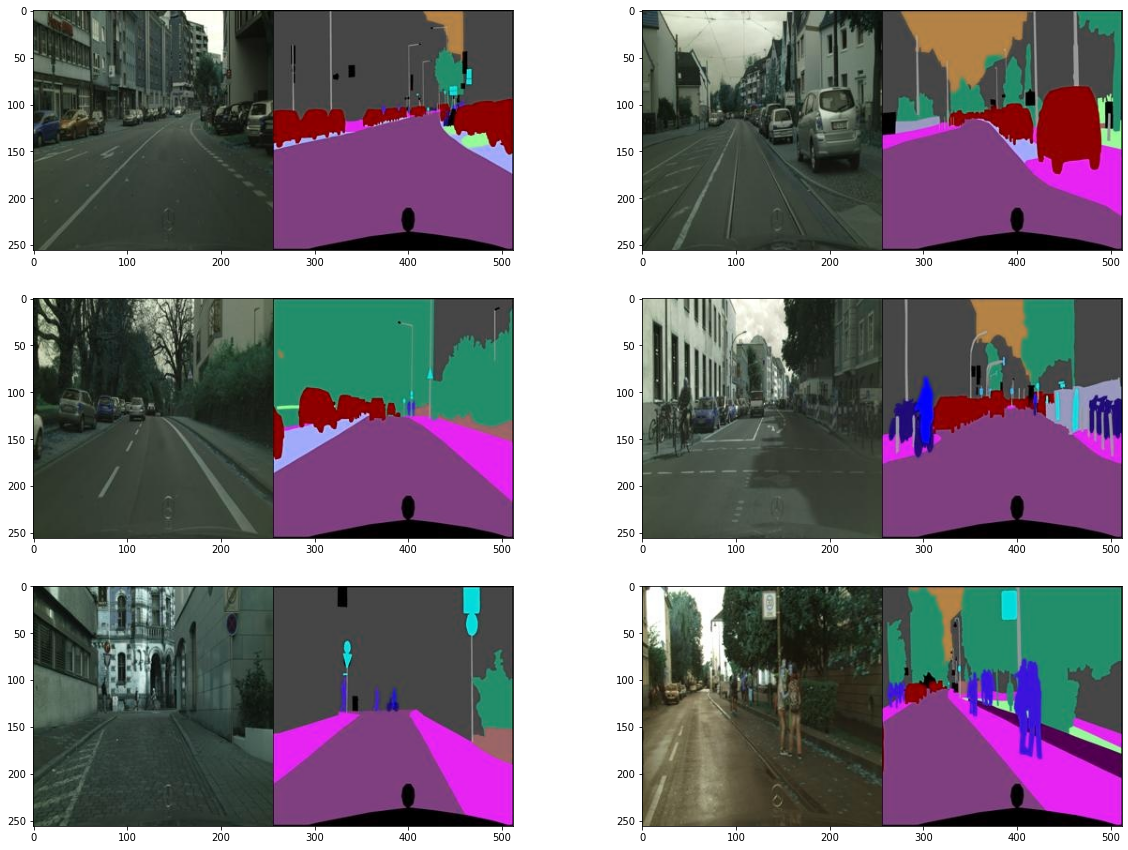

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## 이미지 전처리

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

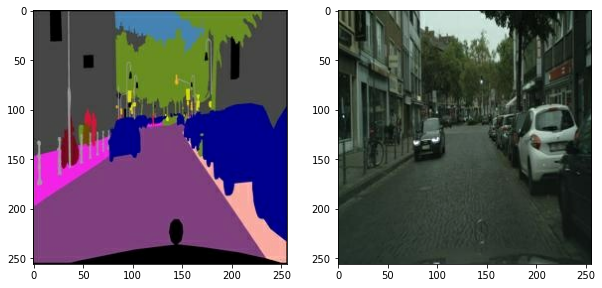

In [6]:
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### augmentation
기존 포켓몬 이미지의 경우엔 위 아래를 구분할 필요가 없었지만, 도로 이미지의 경우 하늘과 땅이 제위치에 있어야 하기때문에 조금 다르게 설정할 필요가 있습니다.  
</br>
아래는 기존과 달라진 점입니다.
* 상하반전을 미적용합니다.
* 이미지 회전을 미적용합니다.
* 50%의 확률로 이미지를 데칼코마니로 만듭니다.(50% 확률로 좌,우 결정)

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    out = stacked
    
    out = image.random_flip_left_right(out)
    # 데칼코마니
    if tf.random.uniform(()) < .5:
        mid = tf.shape(out)[1]//2
        left = out[:,:mid,:]
        right = out[:,mid:,:]
        if tf.random.uniform(()) < .5:
          r_left = image.flip_left_right(left)
          left = tf.concat([left,r_left],axis=1)
          out = left
        else:
          r_right = image.flip_left_right(right)
          right = tf.concat([r_right,right],axis=1)
          out = right

    return out[...,:3], out[...,3:]

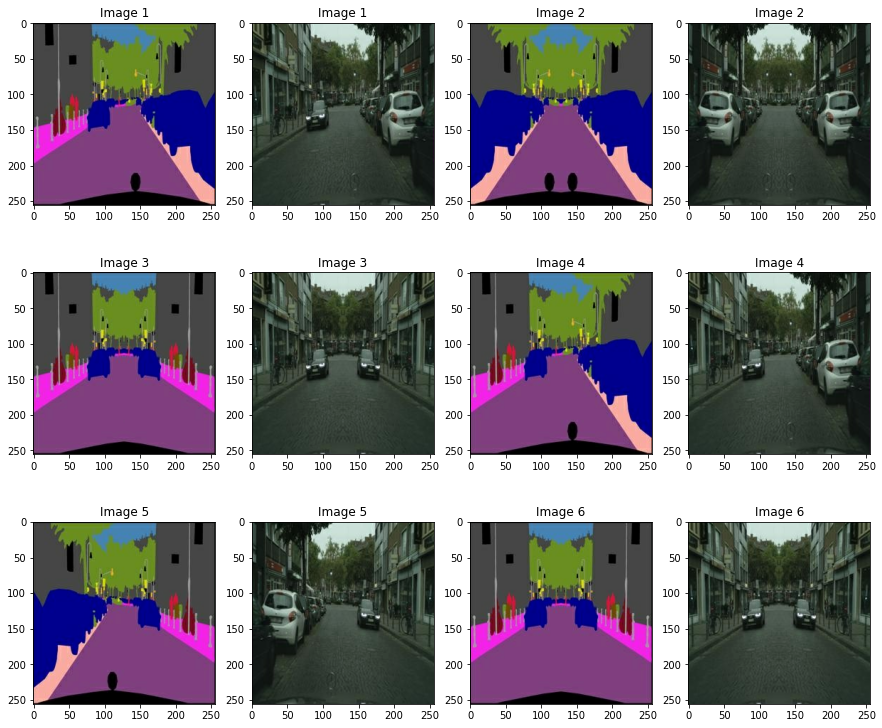

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

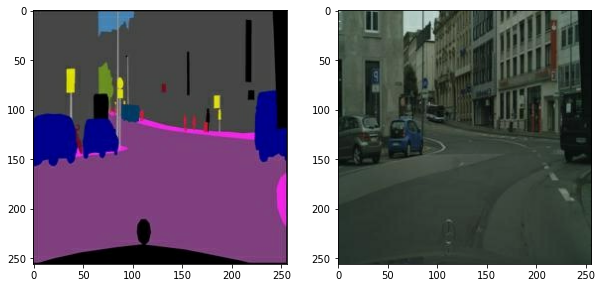

In [9]:
# train image를 생성
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 모델 구성하기
* U-Net을 구성합니다.
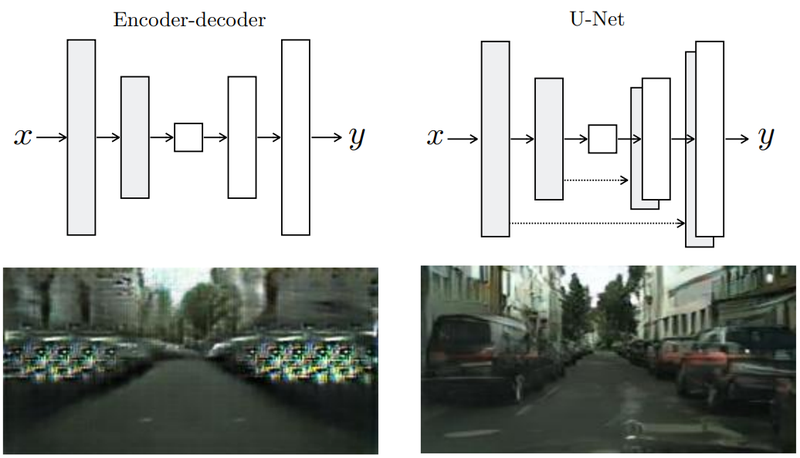

* U-Net Generator는 인코더와 디코더간의 shortcut-connection을 통해 훨씬 더 실제 이미지에 가까운 결과를 얻습니다.

In [10]:
# 인코더블록과 디코더 블록
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

* skip-connection으로 인해 decoder의 각 블록의 input이 늘어남에 따라 conv layer의 필터가 커지게되어 파라미터의 수가 늘어났습니다.

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        
        self.sigmoid = layers.Activation("sigmoid")
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(
                n_filters=f,
                stride=2 if i<3 else 1,
                custom_pad=False if i<3 else True,
                use_bn=False if i==0 or i==4 else True,
                act=True if i<4 else False
            ))
    
    def call(self, x, y):
        out = self.blocks[0]([x,y])
        for i in range(1,6):
            out = self.blocks[i](out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [15]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

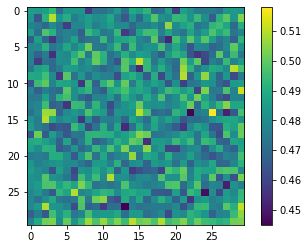

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])
# 시험삼아 랜덤 노이즈 입력
disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

* 판별자 출력의 의미는 각 픽셀값은 sigmoid 함수의 결과값으로 0~1사이의 값을 가지며 해당 픽셀이 진짜인지 가짜인지 판별합니다.

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [18]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [19]:
@tf.function
def train_step(generator,discriminator,sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [20]:
def model_fit(gen,disc,train,epochs=10):
    history = {"Gen_loss":[],"L1_loss":[],"Disc_loss":[]}
    for epoch in range(1, epochs+1):
        for i, (sketch, colored) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(gen,disc,sketch, colored)
                    
            # 10회 반복마다 손실을 기록합니다.
            if (i+1) % 10 == 0:
                print(f"EPOCH[{epoch}] - STEP[{i+1}]")
                history["Gen_loss"].append(g_loss)
                history["L1_loss"].append(l1_loss)
                history["Disc_loss"].append(d_loss)
    return history

In [21]:
generator = UNetGenerator()
discriminator = Discriminator()

In [22]:
history = model_fit(generator,discriminator,train_images,15)

EPOCH[1] - STEP[10]
EPOCH[1] - STEP[20]
EPOCH[1] - STEP[30]
EPOCH[1] - STEP[40]
EPOCH[1] - STEP[50]
EPOCH[1] - STEP[60]
EPOCH[1] - STEP[70]
EPOCH[1] - STEP[80]
EPOCH[1] - STEP[90]
EPOCH[1] - STEP[100]
EPOCH[1] - STEP[110]
EPOCH[1] - STEP[120]
EPOCH[1] - STEP[130]
EPOCH[1] - STEP[140]
EPOCH[1] - STEP[150]
EPOCH[1] - STEP[160]
EPOCH[1] - STEP[170]
EPOCH[1] - STEP[180]
EPOCH[1] - STEP[190]
EPOCH[1] - STEP[200]
EPOCH[1] - STEP[210]
EPOCH[1] - STEP[220]
EPOCH[1] - STEP[230]
EPOCH[1] - STEP[240]
EPOCH[1] - STEP[250]
EPOCH[2] - STEP[10]
EPOCH[2] - STEP[20]
EPOCH[2] - STEP[30]
EPOCH[2] - STEP[40]
EPOCH[2] - STEP[50]
EPOCH[2] - STEP[60]
EPOCH[2] - STEP[70]
EPOCH[2] - STEP[80]
EPOCH[2] - STEP[90]
EPOCH[2] - STEP[100]
EPOCH[2] - STEP[110]
EPOCH[2] - STEP[120]
EPOCH[2] - STEP[130]
EPOCH[2] - STEP[140]
EPOCH[2] - STEP[150]
EPOCH[2] - STEP[160]
EPOCH[2] - STEP[170]
EPOCH[2] - STEP[180]
EPOCH[2] - STEP[190]
EPOCH[2] - STEP[200]
EPOCH[2] - STEP[210]
EPOCH[2] - STEP[220]
EPOCH[2] - STEP[230]
EPOCH[2] -

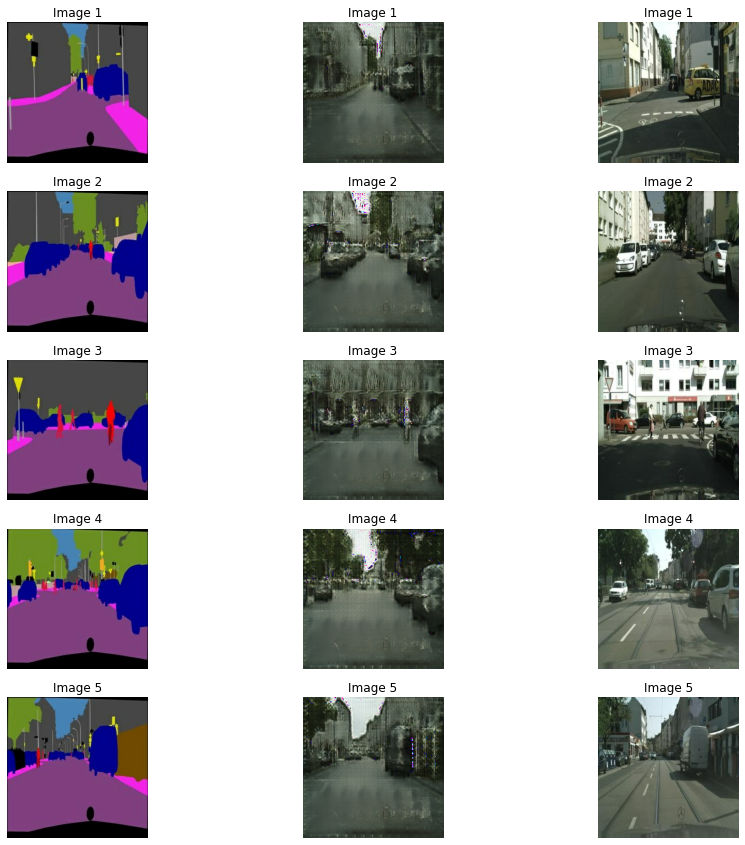

In [23]:
from glob import glob
plt.figure(figsize=(15,15))
val_path = "/content/drive/MyDrive/cityscapes/val/"
f = glob(val_path+"*.jpg")
for i in range(5):
    sketch, colored = load_img(f[i])
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)
    plt.subplot(5,3,i*3+1); plt.imshow(denormalize(sketch))
    plt.title(f"Image {i+1}");plt.axis('off')
    plt.subplot(5,3,i*3+2); plt.imshow(pred[0])
    plt.title(f"Image {i+1}");plt.axis('off')
    plt.subplot(5,3,i*3+3); plt.imshow(denormalize(colored))
    plt.title(f"Image {i+1}");plt.axis('off')

* validation data의 예측 이미지와 원본이미지입니다.  
조금 화질 안좋은 이미지 정도의 결과가 나오는것 같습니다.

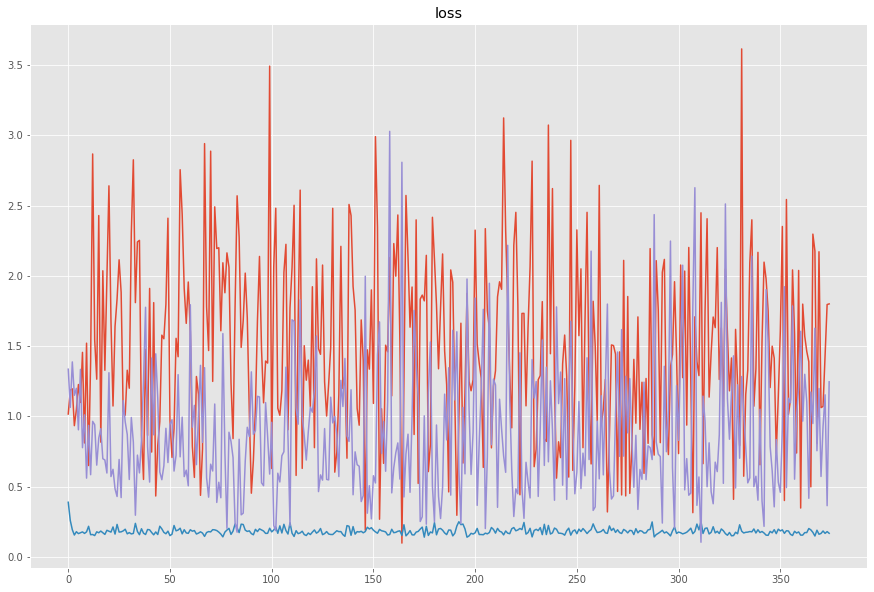

In [24]:
plt.figure(figsize = (15,10))

plt.style.use('ggplot')
plt.plot(history["Gen_loss"],label="Gen_loss")
plt.style.use('ggplot')
plt.plot(history["L1_loss"],label="L1_loss")
plt.style.use('ggplot')
plt.plot(history["Disc_loss"],label="Disc_loss")
plt.title('loss')
plt.show()

# 회고합시다.
U-Net 을 이용한 이미지 채색 모델을 구현해보았습니다.  

시간상의 문제로 augmentation에서 일부 사진을 변경하는 방식으로 진행했지만 원본 사진과 augmentation을 함께 사용하면 더 괜찮은 결과를 얻을 수 있지 않을까 생각됩니다.  

역시 시간상의 이유로 15 epochs 으로만 진행했습니다.  15epochs만으로도 8시간이상의 시간이 걸려 더 많이 반복하지는 못했지만 앞서 말한대로 augmentation으로 dataset을 많이 얻어내고 훈련 횟수를 늘려준다면 지금보다 더 좋은 결과를 얻을 수 있을 것 같습니다.